# Consumer Complaint Classification

The dataset represents consumer complaints about the number of products. Student loan and Bank account or service are products. The RNN has to classify consumer complaints are text data.

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#nltk will be used in preprocessing/EDA of the text data
import pandas as pd
import numpy as np
import re
from sklearn.metrics import accuracy_score
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, Activation,LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from keras.wrappers.scikit_learn import KerasClassifier
from keras.layers import Embedding,SpatialDropout1D
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [14]:
df_consumer_complaints = pd.read_csv("/content/drive/MyDrive/imarticus_classrooms/PGAA-online-01/RNN/Consumer_Complaints (1).csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (5,6,11,16) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [7]:
df_consumer_complaints.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1303617 entries, 0 to 1303616
Data columns (total 18 columns):
 #   Column                        Non-Null Count    Dtype 
---  ------                        --------------    ----- 
 0   Date received                 1303617 non-null  object
 1   Product                       1303617 non-null  object
 2   Sub-product                   1068451 non-null  object
 3   Issue                         1303617 non-null  object
 4   Sub-issue                     769820 non-null   object
 5   Consumer complaint narrative  384865 non-null   object
 6   Company public response       460903 non-null   object
 7   Company                       1303617 non-null  object
 8   State                         1283431 non-null  object
 9   ZIP code                      1185291 non-null  object
 10  Tags                          178463 non-null   object
 11  Consumer consent provided?    700309 non-null   object
 12  Submitted via                 1303617 non-

In [11]:
df_consumer_complaints.sample(5) #Random 5 rows

,Date received,Product,Sub-product,Issue,Sub-issue,Consumer complaint narrative,Company public response,Company,State,ZIP code,Tags,Consumer consent provided?,Submitted via,Date sent to company,Company response to consumer,Timely response?,Consumer disputed?,Complaint ID
206796,08/01/2018,"Credit reporting, credit repair services, or o...",Credit reporting,Problem with a credit reporting company's inve...,Investigation took more than 30 days,Transunion has not responded to my complaint t...,Company has responded to the consumer and the ...,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",GA,310XX,NaN,Consent provided,Web,08/01/2018,Closed with explanation,Yes,NaN,2979689
304723,03/20/2018,Vehicle loan or lease,Loan,Struggling to pay your loan,Denied request to lower payments,"In XX/XX/XXXX, due to a temporary financial ha...",Company has responded to the consumer and the ...,ALLY FINANCIAL INC.,IL,606XX,NaN,Consent provided,Web,03/21/2018,Closed with explanation,Yes,NaN,2848987
767658,03/07/2016,Credit reporting,NaN,Incorrect information on credit report,Public record,NaN,Company has responded to the consumer and the ...,Experian Information Solutions Inc.,AP,96205,Servicemember,Consent not provided,Web,03/07/2016,Closed with explanation,Yes,No,1821120
1229580,12/27/2012,Credit reporting,NaN,Incorrect information on credit report,Account terms,NaN,NaN,"TRANSUNION INTERMEDIATE HOLDINGS, INC.",PR,00985,Older American,NaN,Web,12/27/2012,Closed with explanation,Yes,No,218054
1287311,04/04/2012,Mortgage,Other mortgage,"Loan modification,collection,foreclosure",NaN,NaN,NaN,"BANK OF AMERICA, NATIONAL ASSOCIATION",FL,33178,NaN,NaN,Web,04/05/2012,Closed without relief,Yes,Yes,43916


In [12]:
df_consumer_complaints.Product.value_counts()

Mortgage                                                                        279773
Debt collection                                                                 248580
Credit reporting, credit repair services, or other personal consumer reports    236660
Credit reporting                                                                140432
Credit card                                                                      89190
Bank account or service                                                          86206
Student loan                                                                     52166
Credit card or prepaid card                                                      49515
Checking or savings account                                                      42364
Consumer Loan                                                                    31605
Vehicle loan or lease                                                            11796
Money transfer, virtual currency, or money 

## Filtering observations and columns we wanted to train the model

In [15]:
# Merging some of observations which are same categories
df_consumer_complaints.loc[df_consumer_complaints['Product'] == 'Credit reporting', 'Product'] = 'Credit reporting, credit repair services, or other personal consumer reports'
df_consumer_complaints.loc[df_consumer_complaints['Product'] == 'Credit card', 'Product'] = 'Credit card or prepaid card'
df_consumer_complaints.loc[df_consumer_complaints['Product'] == 'Payday loan', 'Product'] = 'Payday loan, title loan, or personal loan'
df_consumer_complaints.loc[df_consumer_complaints['Product'] == 'Virtual currency', 'Product'] = 'Money transfer, virtual currency, or money service'
df_consumer_complaints = df_consumer_complaints[df_consumer_complaints.Product != 'Other financial service']

In [16]:
df_consumer_complaints.shape

(1302558, 18)

In [17]:
# Filtering two columns one column is for input and another one is for output
df_consumer = df_consumer_complaints.loc[:,["Consumer complaint narrative","Product"]]


In [18]:
df_consumer.sample(5)

,Consumer complaint narrative,Product
476,NaN,Checking or savings account
217581,NaN,"Credit reporting, credit repair services, or o..."
703235,NaN,Bank account or service
711930,NaN,Mortgage
845008,My complaint is with Transunion. \nThey have b...,"Credit reporting, credit repair services, or o..."


In [19]:
# Drop observations which is NAN
df_consumer  = df_consumer.dropna()

In [20]:
df_consumer.shape

(384573, 2)

In [21]:
#Taking observations only three categories
df_Credit = df_consumer.loc[df_consumer['Product'] == "Credit card or prepaid card", :]
df_bank = df_consumer.loc[df_consumer['Product'] == "Bank account or service", :]
df_student = df_consumer.loc[df_consumer['Product'] == "Student loan", :]

# Merging observations of three categories
df_consumer =pd.concat([df_Credit,df_bank,df_student])

In [22]:
df_consumer.shape

(77112, 2)

In [23]:
df_consumer.Product.value_counts()

Credit card or prepaid card    40348
Student loan                   21879
Bank account or service        14885
Name: Product, dtype: int64

In [24]:
df_consumer.sample(5)

,Consumer complaint narrative,Product
880992,On Friday XXXX XXXX I contacted Synchrony Bank...,Credit card or prepaid card
706390,XXXX failed to pay me its advertised promotion...,Bank account or service
593473,I have tried to work with Navient on several o...,Student loan
760944,Bank of America account # XXXX I disputed this...,Credit card or prepaid card
168838,I bought items on XXXX and paid {$13.00} via X...,Credit card or prepaid card


In [ ]:
# We need to convert the text into a time series (sequence of numbers)
#Simplest idea is to convert the letters a-z to 1-26 after removing numbers, special charactars and so on

## Clearning the data set

In [28]:
repalce_space = re.compile('[/(){}\[\]\|@,;]') #Compilation is happening
repalce_space.sub(' ', "ab{c#d")

'ab c#d'

In [30]:
remove_bad_symbols = re.compile('[^0-9a-z #+_]')
remove_bad_symbols.sub('', "ab{c~d")

'abcd'

In [50]:
print(len(stopwords.words('spanish')))
stopwords.words('spanish')[0:5]

313


['de', 'la', 'que', 'el', 'en']

In [36]:
# Reset the index of dataframe
df_consumer = df_consumer.reset_index(drop=True)
# Create a pattern to filter
repalce_space = re.compile('[/(){}\[\]\|@,;]') #Depends in biz problem
#remove_bad_symbols = re.compile('[^a-zA-Z ]')
remove_bad_symbols = re.compile('[^0-9a-z #+_]') #Depends in biz problem
stop_words = set(stopwords.words('english')) #set is optional. It removes duplicates from a list

def clean_text(text):
    #lowercase text
    text = text.lower() 
    # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = repalce_space.sub(' ', text)
    # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing.
    text = remove_bad_symbols.sub('', text)  
    text = text.replace('x', '')
    #text = re.sub(r'\W+', '', text)
    # remove stopwors from text
    text = ' '.join(word for word in text.split() if word not in stop_words) #''.join is converting a list of words into a string
    return text


In [39]:
"hbhdf kmkvd kmmkvv".split()

['hbhdf', 'kmkvd', 'kmmkvv']

In [38]:
clean_text("jnh{xdvj $%%GTH dsdnjv nht dog cat")

'jnh dvj gth dsdnjv nht dog cat'

In [40]:
# Clean the data set
#.apply applies the function 'clean_text' on every element of the column "Consumer complaint narrative"
df_consumer['Consumer complaint narrative'] = df_consumer['Consumer complaint narrative'].apply(clean_text)
df_consumer['Consumer complaint narrative'] = df_consumer['Consumer complaint narrative'].str.replace('\d+', '') #optional, Removing all the digits from the column

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.


In [54]:
df_consumer

,Consumer complaint narrative,Product
0,payments made cleared card issued available cr...,Credit card or prepaid card
1,submitted complaint questioning fraudulent act...,Credit card or prepaid card
2,wanted make payment due date boyfriends checki...,Credit card or prepaid card
3,separate charges total ive attempted multip...,Credit card or prepaid card
4,american epress closed account based internal ...,Credit card or prepaid card
...,...,...
77107,due financial hardship unable pay student loan...,Student loan
77108,husband lost job unemployed almost months rece...,Student loan
77109,daughter father passe away well fargo loans we...,Student loan
77110,private loan sallie mae called try get lower p...,Student loan


## The Following code  creates word clouds from the dataset and visualize

In [42]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud,STOPWORDS
from nltk.corpus import stopwords
stop_word = set(STOPWORDS)


def generate_wordcloud(text,title = None): 
    
    #Creating wordcloud object and getting list of frequent words from text
    wordcloud = WordCloud(background_color='white',
                          max_words=200,
                          max_font_size=40, 
                          scale=3,
                          stopwords = stop_word,).generate(text)
    
    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)
   
    plt.imshow(wordcloud,interpolation='bilinear')
    plt.show()



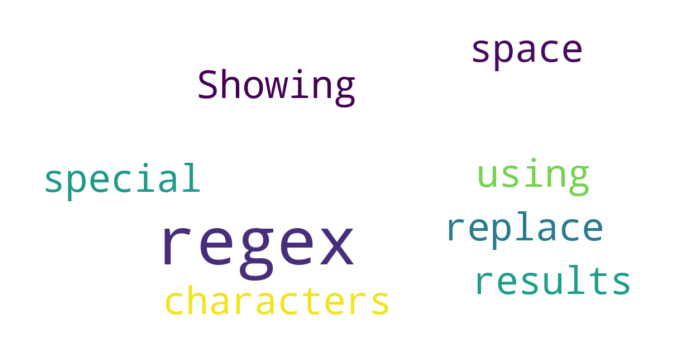

In [49]:
text = "Showing regex results regex for replace all regex the regex regex regex special characters with space using regex in"
generate_wordcloud(text)

## Visualizing most frequent words in the "Credit card or prepaid card" category

In [51]:
df_Credit["Consumer complaint narrative"] = df_Credit["Consumer complaint narrative"].apply(clean_text)
df_Credit["Consumer complaint narrative"] = df_Credit["Consumer complaint narrative"].str.replace('\d+', '')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  


In [53]:
' '.join(df_bank.iloc[:,0])

Output hidden; open in https://colab.research.google.com to view.

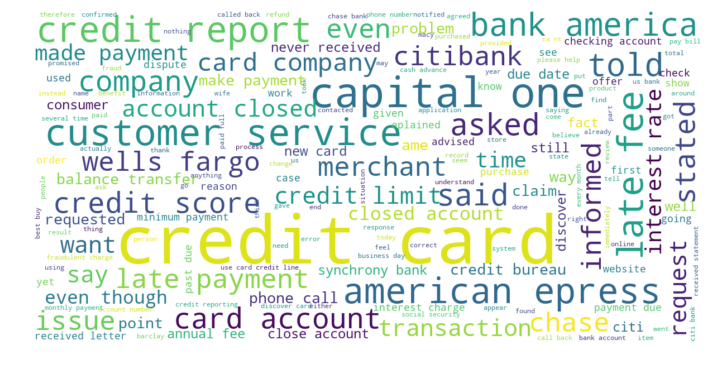

In [ ]:
generate_wordcloud(' '.join(df_bank.iloc[:,0]))

We can notice that frequency words in "Credit card or prepaid card" category.

## Visualizing most frequent words in the "Bank account or service" category



In [ ]:
df_bank["Consumer complaint narrative"] = df_bank["Consumer complaint narrative"].apply(clean_text)
df_bank["Consumer complaint narrative"] = df_bank["Consumer complaint narrative"].str.replace('\d+', '')

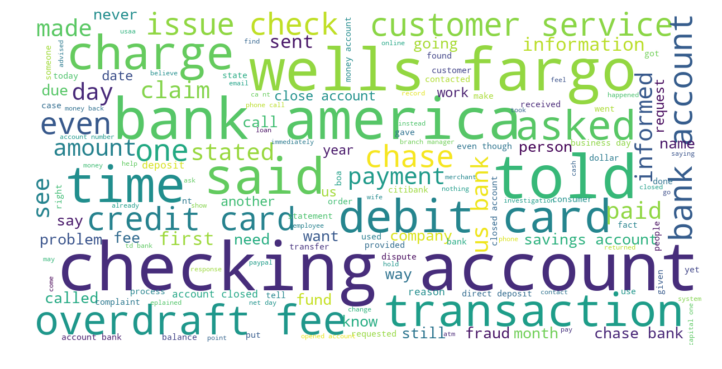

In [ ]:
generate_wordcloud(' '.join(df_bank.iloc[:,0]))

We can notice that frequency words in "Bank account or service" category.

## Visualizing most frequent words in the "Student loan" category

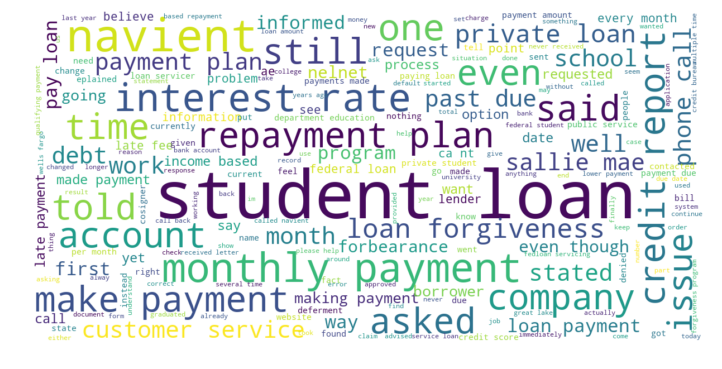

In [ ]:
df_student["Consumer complaint narrative"] = df_student["Consumer complaint narrative"].apply(clean_text)
df_student["Consumer complaint narrative"] = df_student["Consumer complaint narrative"].str.replace('\d+', '')
generate_wordcloud(' '.join(df_student.iloc[:,0]))

We can notice that frequency words in "Student loan" category.

In [55]:
df_consumer

,Consumer complaint narrative,Product
0,payments made cleared card issued available cr...,Credit card or prepaid card
1,submitted complaint questioning fraudulent act...,Credit card or prepaid card
2,wanted make payment due date boyfriends checki...,Credit card or prepaid card
3,separate charges total ive attempted multip...,Credit card or prepaid card
4,american epress closed account based internal ...,Credit card or prepaid card
...,...,...
77107,due financial hardship unable pay student loan...,Student loan
77108,husband lost job unemployed almost months rece...,Student loan
77109,daughter father passe away well fargo loans we...,Student loan
77110,private loan sallie mae called try get lower p...,Student loan


## Tokenizing the words

In [56]:
# The maximum number of words to be used. (most frequent)
max_no_words = 25000 #Kind of randomly decided
# Max number of words in each complaint.
max_seq_len = 250 #Beyond 250 words will be discarded, Padding will happen for short complaints having less than 250 words
# Create tokenizer object
tokenizer = Tokenizer(num_words=max_no_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True) # to assign a label/numb er to each unique word in the entire column of "Consumer complaint narrative"
# Fit the tokenizer on text data
tokenizer.fit_on_texts(df_consumer['Consumer complaint narrative'].values) #Deciding which unique word will have what label/token
# Count how many unique tokes are in these observations
word_index = tokenizer.word_index
print('Number of unique tokens %s' % len(word_index))

Number of unique tokens 60897


In [ ]:
#vocab size = 60897
#there are 60897 unique words in the column "Consumer complaint narrative"
#But we will keep only the top 25000 most frequently occuring words and remove others

In [61]:
tokenizer.word_index

{'account': 1,
 'credit': 2,
 'card': 3,
 'would': 4,
 'payment': 5,
 'bank': 6,
 'told': 7,
 'loan': 8,
 'called': 9,
 'payments': 10,
 'time': 11,
 'received': 12,
 'pay': 13,
 'interest': 14,
 'one': 15,
 'nt': 16,
 'balance': 17,
 'never': 18,
 'back': 19,
 'loans': 20,
 'made': 21,
 'could': 22,
 'get': 23,
 'said': 24,
 'due': 25,
 'information': 26,
 'call': 27,
 'amount': 28,
 'money': 29,
 'paid': 30,
 'also': 31,
 'late': 32,
 'company': 33,
 'month': 34,
 'since': 35,
 'make': 36,
 'days': 37,
 'phone': 38,
 'service': 39,
 'navient': 40,
 'customer': 41,
 'asked': 42,
 'sent': 43,
 'even': 44,
 'letter': 45,
 'check': 46,
 'years': 47,
 'charge': 48,
 'chase': 49,
 'still': 50,
 'number': 51,
 'fee': 52,
 'charges': 53,
 'months': 54,
 'fees': 55,
 'student': 56,
 'report': 57,
 'closed': 58,
 'new': 59,
 'help': 60,
 'charged': 61,
 'statement': 62,
 'day': 63,
 'first': 64,
 'email': 65,
 'us': 66,
 'another': 67,
 'like': 68,
 'online': 69,
 'contacted': 70,
 'accounts':

In [65]:
#.values converts a pandas dataframe into a numpy array
df_consumer['Consumer complaint narrative'].values[100] #complaint from the 100th row

'shocked reviewed credit report found late payment dates   days late sure happened believe made payments received statements thought monthly statement get'

In [66]:
df_consumer['Consumer complaint narrative'].values.shape

(77112,)

In [67]:
foo = tokenizer.texts_to_sequences(df_consumer['Consumer complaint narrative'].values)

In [71]:
df_consumer['Consumer complaint narrative'].values[0]

'payments made cleared card issued available credit reflect payments credit limit balance currently payments amounts last two payments posted available credit shows zero'

In [70]:
foo[0] #'payments' will be coded/tokenized as 10 on any complaint

[10,
 21,
 720,
 3,
 332,
 234,
 2,
 1065,
 10,
 2,
 243,
 17,
 366,
 10,
 491,
 102,
 109,
 10,
 362,
 234,
 2,
 450,
 988]

In [75]:
tokenizer.texts_to_sequences(np.array(["bank payment xyz"])) #'xyz' gets ignored as it is not among 25k most frequently occuring words

[[6, 5]]

In [76]:
# Text to sequences 
# "texts_to_sequences" converts each complaint to a sequence of tokens/numbers ignoring any word beyond the most frequent 25k(hyperparameter) words
X = tokenizer.texts_to_sequences(df_consumer['Consumer complaint narrative'].values) #texts_to_sequences a method inside tokenizer class

# Padding the sequences
X = pad_sequences(X, maxlen=max_seq_len) #Padding with zeros for all the sequences having less than 250 tokens
print('Shape of data tensor:', X.shape)
#pre-padding is a better idea as RNN's have the tendancy to remember the information from the latest values in a sequence

Shape of data tensor: (77112, 250)


In [79]:
X[0]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,   

In [80]:
# Create dummies variables for output variable
Y = pd.get_dummies(df_consumer['Product']).values #One-hot encoding the target
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (77112, 3)


In [81]:
Y

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 0, 1]], dtype=uint8)

## Spilit the dataset into train and test dataset

In [82]:
#Traning and testing dataset
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(53978, 250) (53978, 3)
(23134, 250) (23134, 3)


## Model development with simple RNN

## Training the model

In [84]:
#Create sequential object
model = Sequential()
#Embedding layer
#This layer will convert each and every token, 0-25000 to fixed length vector (100,) through training
model.add(Embedding(max_no_words, 100, input_length=X.shape[1]))
#Dropout layer
model.add(SpatialDropout1D(0.2)) #Avoids overfitting
#RNN layer
model.add(SimpleRNN(100, input_shape = (53978,250), return_sequences = False))
#Fully connected layer
model.add(Dense(3))
model.add(Activation('softmax'))
#Optimizer 
# adam = optimizers.Adam(lr = 0.001)
#Compile the model
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
#Fit the model on the training dataset
#Stop the training automatically if for 3 consecutive epochs the loss does not decrease by at least 0.0001
history = model.fit(X_train, Y_train,epochs = 2, batch_size = 50, validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

Epoch 1/2
972/972 [==============================] - 141s 143ms/step - loss: 0.6341 - accuracy: 0.7357 - val_loss: 1.0398 - val_accuracy: 0.5558
Epoch 2/2
972/972 [==============================] - 133s 137ms/step - loss: 0.7275 - accuracy: 0.6917 - val_loss: 0.8829 - val_accuracy: 0.5906


## Save the model

In [ ]:
# Save the model
model.save('/content/drive/My Drive/Project/RNN/model_rnn.h5')

## Testing the model

In [ ]:
accuracy = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accuracy [0],accuracy [1]))

23134/23134 [==============================] - 55s 2ms/step
Test set
  Loss: 0.795
  Accuracy: 0.643


In [ ]:
from sklearn.metrics import confusion_matrix
y_pred = model.predict_classes(X_test)
y_test = np.argmax(Y_test, axis = 1)
#print(accuracy_score(y_pred, y_test))

confusion_matrix(y_test, y_pred)

array([[  671,  3391,   363],
       [  484, 10338,  1336],
       [   85,  2601,  3865]])

There are 4425 observations belongs to "bank account or service". In which, only  671 observations are correctly predicted.

There are 12158 observations belongs to "Credit card or prepaid card". In which, only 10338 observations are correctly predicted.

There are 6551 observations belongs to "Student loan". In which, only 3865 observations are correctly predicted.


In [ ]:
from sklearn.metrics import classification_report
labels = ['Bank account or service','Credit card or prepaid card','Student loan', ]
print(classification_report(y_test, y_pred, target_names=labels))

                             precision    recall  f1-score   support

    Bank account or service       0.54      0.15      0.24      4425
Credit card or prepaid card       0.63      0.85      0.73     12158
               Student loan       0.69      0.59      0.64      6551

                   accuracy                           0.64     23134
                  macro avg       0.62      0.53      0.53     23134
               weighted avg       0.63      0.64      0.61     23134



The RNN model predicts "Credit card or prepaid card " and "Student loan" observations correctly above 60 % of the f1 score. But the model did not perform poorly on "Banks account or service" category.

## Predictions

In [ ]:
# Single observation
x = np.reshape(X_test[0], (1,-1))
#Prediction on single observation
pred_observation = model.predict_classes(x)
labels = ['Bank account or service','Credit card or prepaid card','Student loan', ]
print(pred_observation[0], labels [pred_observation[0]])

1 Credit card or prepaid card


## Visualizing "Loss" and "Accuracy" on each epoch

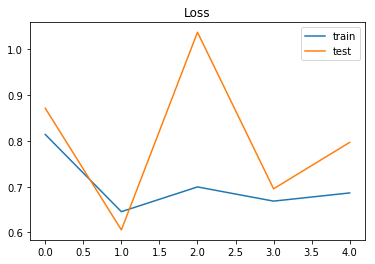

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

The plot shows the training and the testing loss on each epoch.

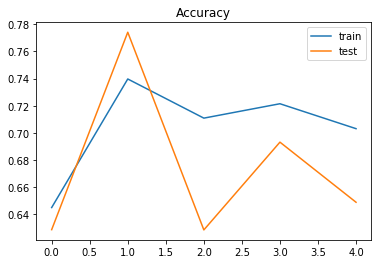

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show();

The plot shows the training and the testing accuracy on each epoch.

The RNN model classifies the customer complains at 64 % accuracy on the test dataset.